In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

# automatically refresh imported modules
%reload_ext autoreload
%autoreload 2

## for data
import json
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
from sklearn import metrics

In [34]:
path = "/Users/victor/Documents/Confidential Dataset/ML_NOAC_NOVA_Extraction.csv"
data = pd.read_csv(path)
data.head()

,CaseNumber,Type,Topics__c,TeamName__c,RequesterEmail__c,EmailTemplateSubjectDispute__c,LastEmailCCAddress__c,SuppliedEmail,LastIncomingEmail__c,attributes.type,attributes.url,Contact.attributes.type,Contact.attributes.url,Contact.Email,Contact
0,100124562,RTCU,T039,US-NOR-CMA-BKG-PREFERRED,NaN,NAM4999926A Case #100124562,op@easywayintl.com,NaN,"<div>\n<div>\n<div dir=""ltr"" style=""color: rgb...",Case,/services/data/v42.0/sobjects/Case/5005p00002e...,Contact,/services/data/v42.0/sobjects/Contact/0035p000...,usa.wcportops@cma-cgm.com,NaN
1,100128892,CRFC,T038,US-NOR-CMA-CS-EXP-PREFERRED,NaN,NAM5085287 Case #100128892,NaN,NaN,NaN,Case,/services/data/v42.0/sobjects/Case/5005p00002e...,NaN,NaN,NaN,NaN
2,100123788,BCON,T847,US-NOR-CMA-CS-EXP-PREFERRED,NaN,NAM4993560 Case #100123788,NaN,NaN,NaN,Case,/services/data/v42.0/sobjects/Case/5005p00002e...,Contact,/services/data/v42.0/sobjects/Contact/0030N000...,ds@srinc.us.com,NaN
3,100080371,CRFC,T036,US-BNA-CMA-CS-IMP-DIVERSIONS,NaN,MOGELIJKE COD'S F119086 // RTM Case #100080371,janneke.van.leeuwen@fclmarine.nl; executivedes...,NaN,"<div class=""WordSection1"">\n<p class=""MsoNorma...",Case,/services/data/v42.0/sobjects/Case/5005p00002e...,Contact,/services/data/v42.0/sobjects/Contact/0030N000...,janneke.van.leeuwen@fclmarine.nl,NaN
4,100095395,BREQ,T035,US-NOR-CMA-BKG-PREFERRED,tina@generallogistics.net,AMEND NAM5088900 [ ref:_00D Case #100095395,bookings@generallogistics.net,tina@generallogistics.net,"<div class=""WordSection1"">\n<p class=""MsoNorma...",Case,/services/data/v42.0/sobjects/Case/5005p00002e...,Contact,/services/data/v42.0/sobjects/Contact/0030N000...,tina@generallogistics.net,NaN


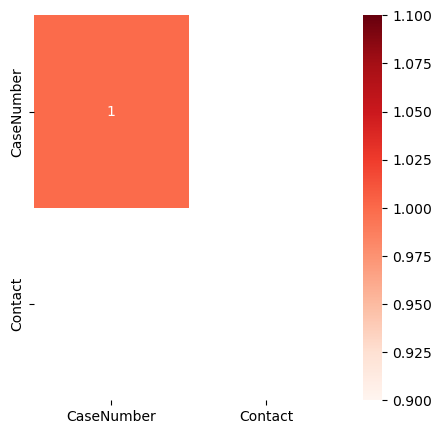

In [39]:
# plot the correlated features above 90%
corr = data.corr()
corr = corr[corr > 0.9]

plt.figure(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()


In [21]:
# create features with fourth and last word in "TeamName"
data["TeamName_division"] = data["TeamName"].apply(
        lambda x: x.split("-")[3]
    )
data["TeamName_client"] = data["TeamName"].apply(
        lambda x: x.split("-")[-1]
    )

# remove TeamName
data.drop(["TeamName","index"], axis=1, inplace = True)

# work on copy so if we mess up it's ok
df = data.copy()

# keep only features useful for prediction, work on copy of data
df.drop(["CaseNumber", "RequesterEmail", "EmailObject", "LastEmailCCAddress", "AttributesURL", 
         "ContactAttributesURL", "ContactEmail","LastEmailContent", "LastIncomingEmailContent"], axis = 1, inplace = True)

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1).drop(feature_to_encode, axis = 1)
    return(res)

# one-hot encodinc for categorical variables
df = encode_and_bind(df, "Topics")
df = encode_and_bind(df, "CMA_in_cc")
df = encode_and_bind(df, "TeamName_division")
df = encode_and_bind(df, "TeamName_client")

In [22]:
df.head()

,Type,LastEmailCCAddressCount,CountMailsInConversation,Topics_Complex Request,Topics_Request from Third Party,Topics_Request to Third Party,Topics_T001,Topics_T002,Topics_T004,Topics_T005,...,TeamName_client_VANGUARD,TeamName_client_VECONINTER,TeamName_client_VINMAR,TeamName_client_WALMART,TeamName_client_WCR,TeamName_client_WESTROCK,TeamName_client_WHIRLPOOL,TeamName_client_WILLIAMSSONOMA,TeamName_client_ZESPRI,TeamName_client_ZHENSHI
0,0,1,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# # plot the correlation with seaborn of df matrix
# corr = df.corr()
# plt.figure(figsize=(20, 20))
# sns.heatmap(corr, annot=True, fmt=".2f")
# plt.show()

In [29]:
# Let's predict the type using a logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop("Type", axis = 1), df["Type"], test_size = 0.2, random_state = 42, stratify=df["Type"])

# fit model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [30]:
predicted = logreg.predict(X_test)
predicted_prob = logreg.predict_proba(X_test)

Accuracy: 1.0
Auc: 1.0
Detail:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34270
           1       1.00      1.00      1.00     15977

    accuracy                           1.00     50247
   macro avg       1.00      1.00      1.00     50247
weighted avg       1.00      1.00      1.00     50247



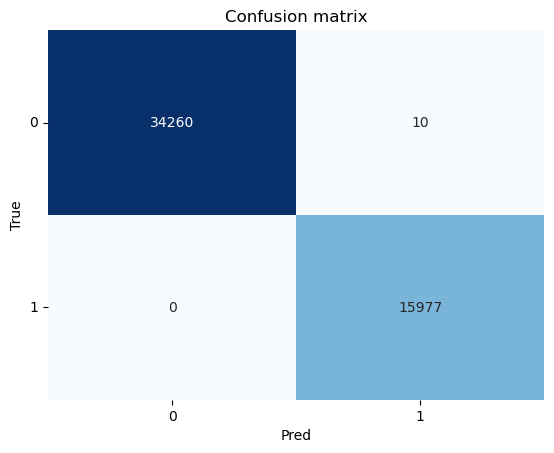

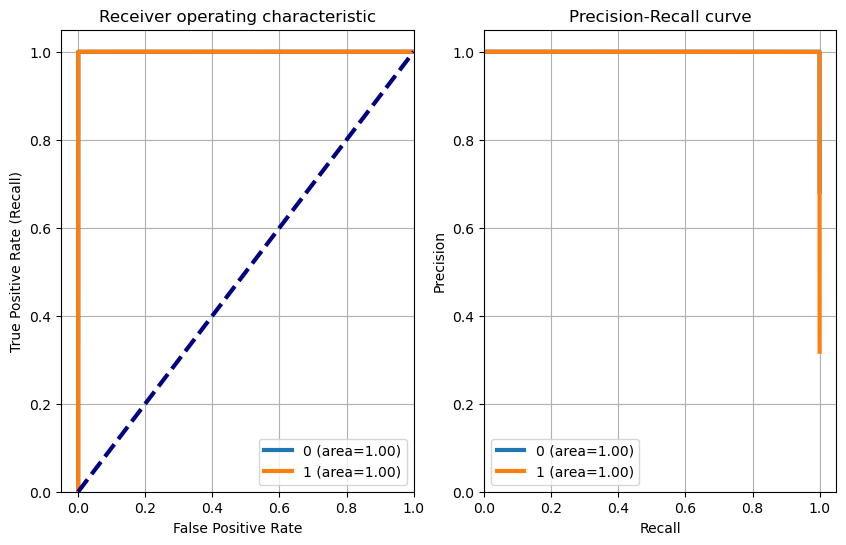

In [31]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
                            
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [33]:
# plot the coefficients on a plot
